In [18]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf

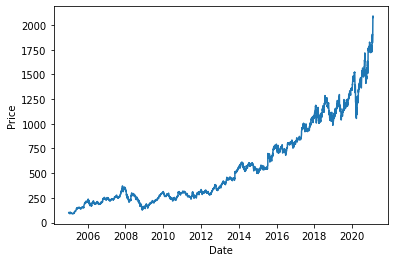

In [19]:
# Download stock data and plot the history diagram

import yfinance as yf
from datetime import datetime

stockName = "GOOGL"
stkTicker = yf.Ticker(stockName)
dfHist = stkTicker.history(start="2005-01-01", end=datetime.today().strftime('%Y-%m-%d'), interval = "1d")
#np.set_printoptions(threshold=np.inf)
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dfHist['Close'])

In [20]:
# Calculate indicators

def SMA(data, period=30, column='Close'):
  return data[column].rolling(window=period).mean()
def EMA (data, period=20, column='Close'):
  return data[column].ewm(span=period, adjust=False).mean()
def MACD(data, periodLong = 26, periodShort=12, periodSignal=9, column='Close'):
  shortEMA = EMA(data, period=periodShort, column=column)
  longEMA = EMA(data, period=periodLong, column=column)
  data['MACD'] = shortEMA - longEMA
  data['signal_line'] = EMA(data,period=periodSignal, column='MACD')
  return data
def RSI(data, period=14, column='Close'):
  delta = data[column].diff(1)
  delta = delta.dropna()
  up = delta.copy()
  down = delta.copy()
  up[up<0] = 0
  down[down>0] =0
  data['up'] = up
  data['down'] = down
  avgGain = SMA(data, period, column='up')
  avgLoss = abs(SMA(data, period, column='down'))
  RS = avgGain / avgLoss
  RSI = 100.0 - (100.0/(1.0 + RS ))
  data['RSI'] = RSI 
  return data

In [21]:
MACD(dfHist)
RSI(dfHist)
dfHist['SMA'] = SMA(dfHist)
dfHist['EMA'] = EMA(dfHist)
dfHist['Target'] = np.where(dfHist['Close'].shift(-1) > dfHist['Close'], 1, 0)
dfHist = dfHist[30:]

In [22]:
dfHist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,signal_line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,,,,,,,
2005-02-15,96.896896,100.020020,96.636635,97.712715,51514034,0,0.0,-0.443869,-0.370881,1.121124,0.000000,54.411551,97.049383,97.372141,1
2005-02-16,97.447449,99.764763,97.247246,99.304306,33031535,0,0.0,-0.237886,-0.344282,1.591591,0.000000,57.388074,97.114615,97.556157,0
2005-02-17,99.014015,99.974976,98.503502,99.049049,20807971,0,0.0,-0.094155,-0.294257,0.000000,-0.255257,55.545772,97.187855,97.698337,1
2005-02-18,99.354355,99.519524,98.428429,99.074074,16954828,0,0.0,0.021525,-0.231100,0.025024,0.000000,51.851266,97.344678,97.829360,0
2005-02-22,98.348351,99.549553,95.290291,95.780785,26940433,0,0.0,-0.150801,-0.215041,0.000000,-3.293289,49.597213,97.303304,97.634257,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04,2060.620117,2069.300049,2035.099976,2053.629883,2429800,0,0.0,59.463457,38.175681,0.000000,-5.250000,78.332242,1811.054655,1871.535219,1
2021-02-05,2059.560059,2095.939941,2050.000000,2088.830078,1489700,0,0.0,69.225000,44.385545,35.200195,0.000000,80.030267,1823.341659,1892.229968,0
2021-02-08,2100.000000,2115.000000,2063.350098,2084.520020,1441400,0,0.0,75.740221,50.656480,0.000000,-4.310059,77.333429,1835.217993,1910.543306,0


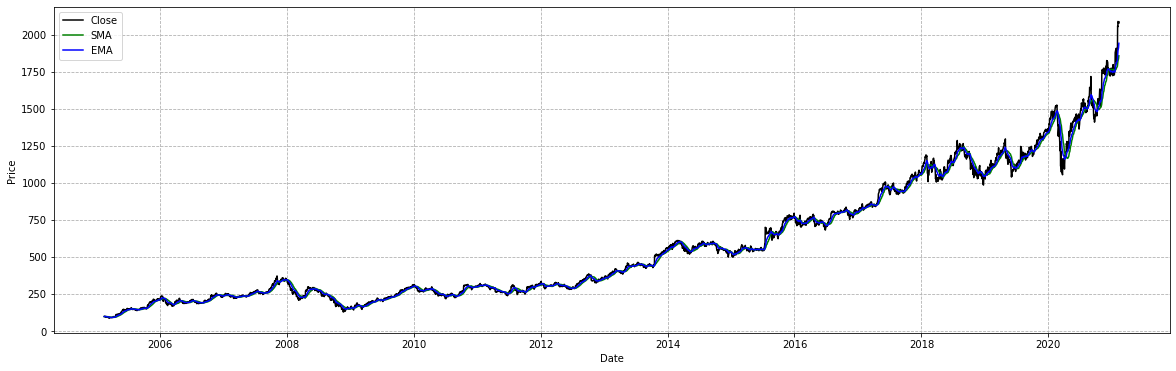

In [23]:
plt.figure(figsize=(20, 6))
plt.grid(ls='--')
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dfHist['Close'], color='black',label ='Close')
plt.plot(dfHist['SMA'], color='green', label='SMA')
plt.plot(dfHist['EMA'], color='blue', label='EMA')
plt.legend()

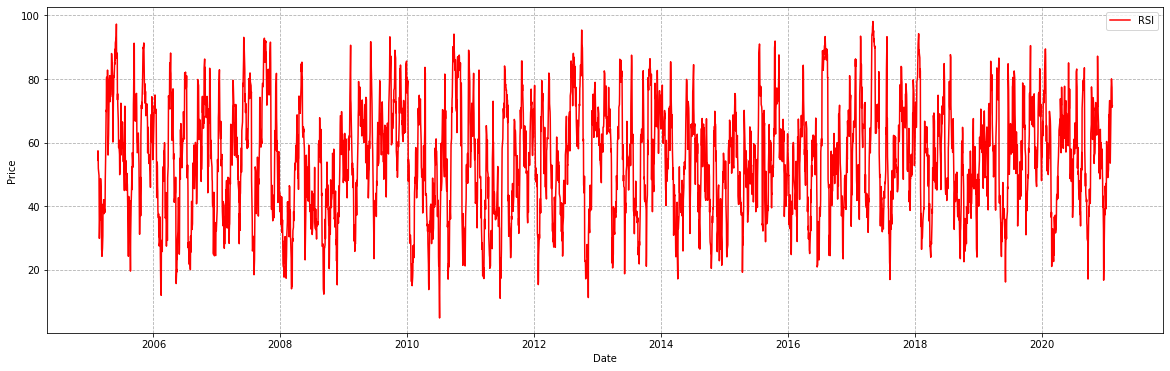

In [24]:
plt.figure(figsize=(20, 6))
plt.grid(ls='--')
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dfHist['RSI'], color='red', label='RSI')
plt.legend()

In [25]:
# Preprocess the historical data
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  1-4044(4044)    dataClose   dataset                                              |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         datasetTrain                           |   datasetTest                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         0-2446  xTrain             | 2447-2546 |                                  |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|       0-99     |     100-2546     yTrain      |                                  |
# -----------------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ------------------x = Close--------------------
dataset = dfHist[['Close','SMA','EMA','MACD', 'RSI','signal_line']].values
target = dfHist['Target'].values
# ------------------With scaler--------------------
minmaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True)
_dataset = minmaxScaler.fit_transform(dataset)
print("The max =", minmaxScaler.data_max_,", the Min =",minmaxScaler.data_min_)

The max = [2088.83007812 1857.00965576 1941.50364746   81.98717282   98.09370238
   61.49810551] , the Min = [ 87.58258057  91.51001027  90.8367743  -93.91052932   4.78969352
 -80.92634344]


In [26]:
# Get train set and test set

from sklearn.model_selection import train_test_split 

_xTrain, _xTest, _yTrain, _yTest = train_test_split(_dataset, target, test_size=0.33, random_state=42)

In [27]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(_xTrain,_yTrain)

In [28]:
print(tree.score(_xTest, _yTest))

0.49134687735139204


In [29]:
np.set_printoptions(threshold=np.inf)
pred = tree.predict(_xTest)
cmp = np.where(pred == _yTest, 1, 0)
cmp.mean()

0.49134687735139204